### Moving Least Squares in 2D for a surface z(x,y) 
for each point $\vec{q}$ \
    - find the neighbor points within radius $r$ (or k-nearest) \
    - estimate the local tangent plane via weighted PCA \
    - Project neighbors to that plane
$$ \mathbf{C} = \frac{\Sigma_{i} w_i (\vec{p_i} - \langle \vec{p} \rangle) (\vec{p_i} -  \langle \vec{p} \rangle)^T}{\Sigma_{i} w_i}$$
This is covariance matrix for the experimental point clouds $ \{ \vec{p_i}\} = \{(x_i,y_i,z_i)\}$ \
$ \{\vec{p_i}\}$ are the nearest-neighbors to $\vec{q}$. We've gathered them to construct the local smooth surface \
For each pair of points $(\vec{q},\vec{p_i})$ we calculate the weight $w_i = \mathcal{N}(\vert \vec{p_i} - \vec{q} \vert,h)$ \
$\langle \vec{p} \rangle$ is the weighted-mean position of the $\{ \vec{p_i} \}$ points $\Sigma_i w_i \vec{p_i}$


This is computed for a small collection of points $\{p_i\}$ rather than for all points. \
We want a localized smooth surface so we pick $k = 30$ nearest neighbors for each experimental data point $x_i,y_i,z_i$ and construct a locally smooth surface for them. The eigenvalues and eigenvectors of $\mathbf{C}$ are $\lambda_1 < \lambda_2 < \lambda_3$ and $\vec{n},\vec{u},\vec{v}$.

$\vec{n}$ is the normal i.e direction along which the point needs to be shifted up/down \
$\lambda_1$ is how much the point needs to be shifted up/down

$\vec{u},\vec{v}$ span the locally smooth surface around the point we're focussed on \
$\lambda_2, \lambda_3$ is how large the locally smooth surface is


Project each neighbor $\vec{p_i}$ onto the $UV$ space so that 
$$ 
u_i = (\vec{p_i} - \vec{\langle p \rangle}).\vec{u} \quad \quad
v_i = (\vec{p_i} - \vec{\langle p \rangle}).\vec{v} \quad \quad
z_i = (\vec{p_i} - \vec{\langle p \rangle}).\vec{n} 
$$
We've replaced ${(x_i - \langle x \rangle, y_i - \langle y \rangle, z_i - \langle z \rangle)}$ with ${(u_i,v_i,z_i)}$ \
$(u_i,v_i)$ are the 2D coordinates of the point $\vec{p_i}$ on the plane \
$z_i$ is the height of the point $\vec{p_i}$ above/below the plane \
The centre of this UV surface is $\vec{\langle p \rangle}$ \
So we're basically doing a series approximation around this central point $\vec{\langle p \rangle}$

Perform least squares minimization for $\{ a_0,a_1,a_2,a_3,a_4,a_5\}$ that minimizes $z(\vec{u},\vec{v})$ \
$z(u,v)=a_0 + a_1.\vec{u} + a_2.\vec{v} + a_3.\vec{u^2} + a_4. \vec{uv} + a_5.\vec{v^2}$

Taking the $0^{th}$ order approximation is equivalent to approximating 
$$\vec{p_i} \approx \vec{\langle p \rangle} + a_0.\vec{n}$$

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial import cKDTree
import random

In [2]:
np.random.seed(0)
n = 5000
x = np.random.uniform(-2*np.pi,2*np.pi,n)
y = np.random.uniform(-2*np.pi,2*np.pi,n)
z_true = np.sin(x) * np.cos(y) 
z_noisy = z_true + 0.2 * np.random.randn(n) # generate n random numbers 

points = np.vstack([x,y,z_noisy]).T # before transpose, row[i] = [x_i,y_i,j_i]. after transpose row[0] = [x_0,x_1,x_2,...x_n], row[1] = [y_0,y_1,y_2,...y_n], row[2] = [z_0,z_1,z_2,...z_n]

# returns the distances and indices of [1,2,3]'s 5 nearest neighbors
dist,idx = cKDTree(points).query([0,0,0],5)
print(points[idx]) # how convenient! this prints [points[i] for i in idx] 

[[-0.0877528  -0.0068517  -0.05891029]
 [ 0.04646171 -0.20827381 -0.07828462]
 [ 0.03419009  0.23618724  0.03386281]
 [ 0.2026164   0.11786627  0.07816962]
 [-0.0759281   0.07409191 -0.25215207]]


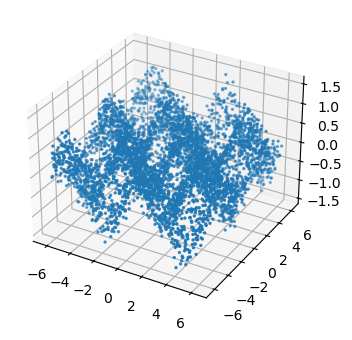

In [3]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z_noisy,s=2)
plt.show()

In [4]:
def gaussian_weight(r,h):
    return np.exp(-r**2/h**2)

In [12]:
# k : number of nearest neighbors to use for computing the Covariance Matrix and construting the localized smooth surface
# h: variance for gaussian weights

def mls_surface(points, h=1.0, k = 30):
    tree = cKDTree(points) # data-structure for quick lookup of nearest-neighbors
    smoothed = np.zeros_like(points) # storage vector. will be populated

    # iterate over all points
    for i,p0 in enumerate(points):
        # find neighbors
        dists,idx = tree.query(p0,k)
        neighbors = points[idx] # row[i] is [pi[x],pi[y], pi[z]]

        # Compute weights
        w = gaussian_weight(dists,h) #  w[i] = gaussian_weight(dist[i],h)
        W = np.diag(w) # W[i,i] = w[i]. W[i,j] = 0 if i ≠ j

        # weigted average position of all neighbors. each neighbor-point is weighted by gaussian(r,h)
        p_bar = np.sum(w[:,None] * neighbors, axis=0) / np.sum(w) # this is just an element-wise product. 
        # [w[i] * neigh[i][x], w[i] * neigh[i][y], w[i] * neigh[i][z]] 

        # construct the Covariance matrix for these k=30 points
        X = neighbors - p_bar # p - <p>
        C = X.T @ W @ X
        eigvals,eigvecs = np.linalg.eigh(C)

        # Local frame using v2,v3
        n = eigvecs[:,0] # smallest eigenvalue is the normal
        u_axis,v_axis = eigvecs[:,1],eigvecs[:,2] # spans the local surface. 
        # constructing a surface using u,v gives a smooth surface approximation for the nearby points

        # project the k-nearest-neighbors onto the UV frame
        # X[i] is p_i - <p> i.e the ith point. 
        # X[i] @ u is the ith point's projection onto u
        # X[i] @ v is the ith point's projection onto v
        # X[i] @ n is the ith point's projection on the normal n
        # Thus we've converted from (x,y,z) to (u,v,n) 
        
        UV = np.stack([X @ u_axis, X @ v_axis],axis=1)
        U,V = UV[:,0],UV[:,1]
        z_local = X@n
        """
        Stacking X@u and X@v is just a stylistic choice so that UV[i] = 2D coordinates of ith point in U-V basis
        U = X @ u_axis
        V = X @ v_axis
        """

        # Build polynomial basis [1,u,v,u^2,v^2,uv]
        A = np.vstack([np.ones_like(U), U, V, U**2, U*V, V**2]).T

        # solve weighted least squares in U-V space
        # find a set of parameters {a0,a1,a2,a3,a4,a5} that minimizes the cost of  
        ATA = A.T @ W @ A
        ATz = A.T @ W @ z_local
        a = np.linalg.solve(ATA,ATz)

        # MLS Projection: evaluate at (u=0,v=0) i.e at <p>
        p_proj = p_bar + a[0] *  n 
        smoothed[i] = p_proj
    return smoothed

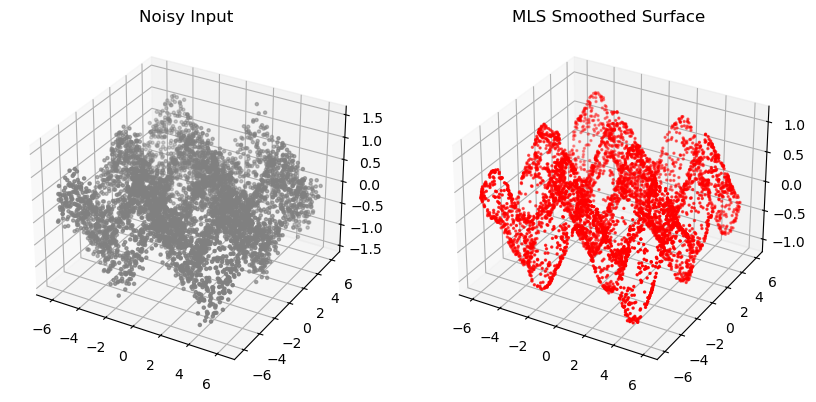

In [13]:
smoothed_points = mls_surface(points, h=1.0,k=40)
# 5. Visualization
fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(points[:,0], points[:,1], points[:,2], s=5, c='gray')
ax1.set_title('Noisy Input')

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(smoothed_points[:,0], smoothed_points[:,1], smoothed_points[:,2], s=2, c='red')
ax2.set_title('MLS Smoothed Surface')

plt.show()


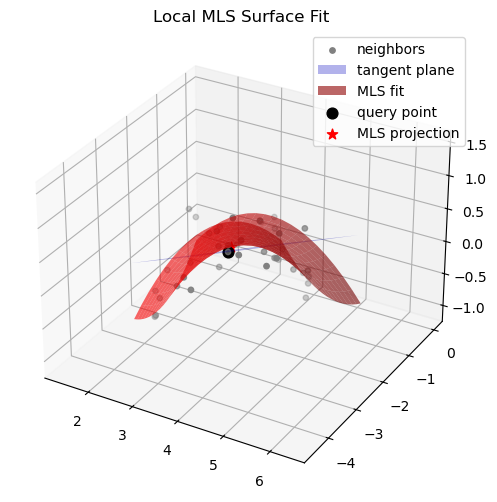

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

# --- Generate a noisy surface: z = sin(x)*cos(y) ---
np.random.seed(2)
n = 500
x = np.random.uniform(-2*np.pi, 2*np.pi, n)
y = np.random.uniform(-2*np.pi, 2*np.pi, n)
z_true = np.sin(x) * np.cos(y)
z_noisy = z_true + 0.2*np.random.randn(n)
points = np.vstack([x, y, z_noisy]).T

# --- Weight function ---
def gaussian_weight(r, h):
    return np.exp(-(r**2)/(h**2))

# --- Pick a query point ---
i0 = 100  # index of point to visualize
p0 = points[i0]

# --- Neighborhood and weights ---
k = 40
h = 1.0
tree = cKDTree(points)
dists, idx = tree.query(p0, k=k)
neighbors = points[idx]
w = gaussian_weight(dists, h)
W = np.diag(w)

# --- Weighted centroid and PCA ---
p_bar = np.sum(w[:,None]*neighbors, axis=0)/np.sum(w)
X = neighbors - p_bar
C = X.T @ W @ X
eigvals, eigvecs = np.linalg.eigh(C)
n_vec = eigvecs[:,0]    # normal
u_axis, v_axis = eigvecs[:,1], eigvecs[:,2]

# --- Project neighbors to (u,v) frame ---
U = X @ u_axis
V = X @ v_axis
Z = X @ n_vec

# --- Fit quadratic polynomial z(u,v) ---
A = np.vstack([np.ones_like(U), U, V, U**2, U*V, V**2]).T
ATA = A.T @ W @ A
ATZ = A.T @ W @ Z
a = np.linalg.solve(ATA, ATZ)

# --- Evaluate on grid in local coords ---
u_grid = np.linspace(U.min(), U.max(), 20)
v_grid = np.linspace(V.min(), V.max(), 20)
Umesh, Vmesh = np.meshgrid(u_grid, v_grid)
Zmesh = (a[0] + a[1]*Umesh + a[2]*Vmesh + 
         a[3]*Umesh**2 + a[4]*Umesh*Vmesh + a[5]*Vmesh**2)

# --- Convert mesh back to 3D space ---
surface_pts = (p_bar 
               + Umesh[...,None]*u_axis
               + Vmesh[...,None]*v_axis
               + Zmesh[...,None]*n_vec)

# --- MLS projection of p0 ---
z_fit = a[0]
p_proj = p_bar + z_fit*n_vec

# --- Plot everything ---
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# neighbors
ax.scatter(neighbors[:,0], neighbors[:,1], neighbors[:,2], color='gray', s=15, label='neighbors')

# tangent plane (flat)
plane_pts = (p_bar 
             + Umesh[...,None]*u_axis 
             + Vmesh[...,None]*v_axis)
ax.plot_surface(plane_pts[...,0], plane_pts[...,1], plane_pts[...,2],
                alpha=0.3, color='blue', label='tangent plane')

# fitted MLS patch
ax.plot_surface(surface_pts[...,0], surface_pts[...,1], surface_pts[...,2],
                alpha=0.6, color='red', label='MLS fit')

# highlight point and projection
ax.scatter(*p0, color='k', s=60, label='query point')
ax.scatter(*p_proj, color='red', s=60, marker='*', label='MLS projection')

ax.set_title("Local MLS Surface Fit")
ax.legend()
plt.show()


### SCRATCH PAD

In [95]:
eigvals,eigvecs = np.linalg.eigh(m[:3])

In [97]:
eigvals

array([-1.17761678, -0.33892171,  7.51653849])

In [100]:
eigvecs,eigvecs[:,2]

(array([[-0.76567677,  0.42509024, -0.48273945],
        [-0.11548497, -0.82915294, -0.54696309],
        [ 0.63277351,  0.36304778, -0.68395468]]),
 array([-0.48273945, -0.54696309, -0.68395468]))

In [118]:
m @ eigvecs[:,2]

array([-1.71365722, -3.42731444, -5.14097165, -6.85462887, -8.56828609])

In [119]:
m

array([[1, 1, 1],
       [2, 2, 2],
       [3, 3, 3],
       [4, 4, 4],
       [5, 5, 5]])

In [92]:
x = np.array([1,2,3,4,5])
m = np.array([[1,1,1],[2,2,2],[3,3,3],[4,4,4],[5,5,5]])
print("x = ", x)
print("m = ", list(m))
p = x[:,None]*m
prodsum = np.sum(prod,axis=0)
print("p = ", list(p))
print(prodsum)


x =  [1 2 3 4 5]
m =  [array([1, 1, 1]), array([2, 2, 2]), array([3, 3, 3]), array([4, 4, 4]), array([5, 5, 5])]
p =  [array([1, 1, 1]), array([4, 4, 4]), array([9, 9, 9]), array([16, 16, 16]), array([25, 25, 25])]
[55 55 55]


In [81]:
w = gaussian_weight(dist,0.1)

In [84]:
w[:,None] * points[idx]

array([[-2.85806982e-02, -2.23156910e-03, -1.91868205e-02],
       [ 2.65036766e-04, -1.18807984e-03, -4.46567775e-04],
       [ 1.02481730e-04,  7.07950033e-04,  1.01500729e-04],
       [ 4.51888089e-04,  2.62872916e-04,  1.74338902e-04],
       [-4.26918054e-05,  4.16593768e-05, -1.41776593e-04]])

In [77]:
points[idx]

array([[-0.0877528 , -0.0068517 , -0.05891029],
       [ 0.04646171, -0.20827381, -0.07828462],
       [ 0.03419009,  0.23618724,  0.03386281],
       [ 0.2026164 ,  0.11786627,  0.07816962],
       [-0.0759281 ,  0.07409191, -0.25215207]])

In [63]:
np.sum(dist[:,None])

np.float64(1.094910283368892)

In [73]:
points[idx]

array([[-0.0877528 , -0.0068517 , -0.05891029],
       [ 0.04646171, -0.20827381, -0.07828462],
       [ 0.03419009,  0.23618724,  0.03386281],
       [ 0.2026164 ,  0.11786627,  0.07816962],
       [-0.0759281 ,  0.07409191, -0.25215207]])

In [75]:
# dist.T * points[idx] # incompatible shapes. 
dist[:,None] * points[idx] # dist[:,None] is basically converting row-vector into column-vector

array([[-0.00929431, -0.0007257 , -0.00623946],
       [ 0.01056073, -0.04734057, -0.01779407],
       [ 0.00824116,  0.05693047,  0.00816228],
       [ 0.05006567,  0.02912426,  0.01931539],
       [-0.02077093,  0.02026862, -0.06897885]])